# The Agent Loop: Building Production Agents with LangChain 1.0

In this notebook, we'll explore the foundational concepts of AI agents and learn how to build production-grade agents using LangChain's new `create_agent` abstraction with middleware support.

**Learning Objectives:**
- Understand what an "agent" is and how the agent loop works
- Learn the core constructs of LangChain (Runnables, LCEL)
- Master the `create_agent` function and middleware system
- Build an agentic RAG application using Qdrant

## Table of Contents:

- **Breakout Room #1:** Introduction to LangChain, LangSmith, and `create_agent`
  - Task 1: Dependencies
  - Task 2: Environment Variables
  - Task 3: LangChain Core Concepts (Runnables & LCEL)
  - Task 4: Understanding the Agent Loop
  - Task 5: Building Your First Agent with `create_agent()`
  - Question #1 & Question #2
  - Activity #1: Create a Custom Tool

- **Breakout Room #2:** Middleware - Agentic RAG with Qdrant
  - Task 6: Loading & Chunking Documents
  - Task 7: Setting up Qdrant Vector Database
  - Task 8: Creating a RAG Tool
  - Task 9: Introduction to Middleware
  - Task 10: Building Agentic RAG with Middleware
  - Question #3 & Question #4
  - Activity #2: Enhance the Agent

---
# 🤝 Breakout Room #1
## Introduction to LangChain, LangSmith, and `create_agent`

## Task 1: Dependencies

First, let's ensure we have all the required packages installed. We'll be using:

- **LangChain 1.0+**: The core framework with the new `create_agent` API
- **LangChain-OpenAI**: OpenAI model integrations
- **LangSmith**: Observability and tracing
- **Qdrant**: Vector database for RAG
- **tiktoken**: Token counting for text splitting

In [ ]:
# Run this cell to install dependencies (if not using uv sync)
# !pip install langchain>=1.0.0 langchain-openai langsmith langgraph qdrant-client langchain-qdrant tiktoken nest-asyncio

In [1]:
# Core imports we'll use throughout the notebook
import os
import getpass
from uuid import uuid4

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

## Task 2: Environment Variables

We need to set up our API keys for:
1. **OpenAI** - For the GPT-5 model
2. **LangSmith** - For tracing and observability (optional but recommended)

In [2]:
# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
# Optional: Set up LangSmith for tracing
# This provides powerful debugging and observability for your agents

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - The Agent Loop - c46f3c7f


## Task 3: LangChain Core Concepts

Before diving into agents, let's understand the fundamental building blocks of LangChain.

### What is a Runnable?

A **Runnable** is the core abstraction in LangChain - think of it as a standardized component that:
- Takes an input
- Performs some operation
- Returns an output

Every component in LangChain (models, prompts, retrievers, parsers) is a Runnable, which means they all share the same interface:

```python
result = runnable.invoke(input)           # Single input
results = runnable.batch([input1, input2]) # Multiple inputs
for chunk in runnable.stream(input):       # Streaming
    print(chunk)
```

### What is LCEL (LangChain Expression Language)?

**LCEL** allows you to chain Runnables together using the `|` (pipe) operator:

```python
chain = prompt | model | output_parser
result = chain.invoke({"query": "Hello!"})
```

This is similar to Unix pipes - the output of one component becomes the input to the next.

In [4]:
# Let's see LCEL in action with a simple example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Create our components (each is a Runnable)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks like a pirate."),
    ("human", "{question}")
])

model = ChatOpenAI(model="gpt-5", temperature=0.7)

output_parser = StrOutputParser()

# Chain them together with LCEL
pirate_chain = prompt | model | output_parser

/Users/preetam/genai/learning/ai_makerspace/Learn-AI-Engineering/03_The_Agent_Loop/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [5]:
# Invoke the chain
response = pirate_chain.invoke({"question": "What is the capital of France?"})
print(response)

Arrr, that’d be Paris, matey!


## Task 4: Understanding the Agent Loop

### What is an Agent?

An **agent** is a system that uses an LLM to decide what actions to take. Unlike a simple chain that follows a fixed sequence, an agent can:

1. **Reason** about what to do next
2. **Take actions** by calling tools
3. **Observe** the results
4. **Iterate** until the task is complete

### The Agent Loop

The core of every agent is the **agent loop**:

```
                          AGENT LOOP                         
                                                             
      +----------+     +----------+     +----------+         
      |  Model   | --> |   Tool   | --> |  Model   | --> ... 
      |   Call   |     |   Call   |     |   Call   |         
      +----------+     +----------+     +----------+         
           |                                  |              
           v                                  v              
      "Use search"                   "Here's the answer"     
```

1. **Model Call**: The LLM receives the current state and decides whether to:
   - Call a tool (continue the loop)
   - Return a final answer (exit the loop)

2. **Tool Call**: If the model decides to use a tool, the tool is executed and its output is added to the conversation

3. **Repeat**: The loop continues until the model decides it has enough information to answer

### Why `create_agent`?

LangChain 1.0 introduced `create_agent` as the new standard way to build agents. It provides:

- **Simplified API**: One function to create production-ready agents
- **Middleware Support**: Hook into any point in the agent loop
- **Built on LangGraph**: Uses the battle-tested LangGraph runtime under the hood

## Task 5: Building Your First Agent with `create_agent()`

Let's build a simple agent that can perform calculations and tell the time.

### Step 1: Define Tools

Tools are functions that the agent can call. We use the `@tool` decorator to create them.

In [6]:
from langchain_core.tools import tool

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool belt
tools = [calculate, get_current_time]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:60]}...")

Tools created:
  - calculate: Evaluate a mathematical expression. Use this for any math ca...
  - get_current_time: Get the current date and time. Use this when the user asks a...


### Step 2: Create the Agent

Now we use `create_agent` to build our agent. The function takes:
- `model`: The LLM to use (can be a string like `"gpt-5"` or a model instance)
- `tools`: List of tools the agent can use
- `prompt`: Optional system prompt to customize behavior

In [7]:
from langchain.agents import create_agent

# Create our first agent
simple_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations and tell the time. Always explain your reasoning."
)

print("Agent created successfully!")
print(f"Type: {type(simple_agent)}")

Agent created successfully!
Type: <class 'langgraph.graph.state.CompiledStateGraph'>


### Step 3: Run the Agent

The agent is a Runnable, so we can invoke it like any other LangChain component.

In [8]:
# Test the agent with a simple calculation
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 25 * 48?"}]}
)

# Print the final response
print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
To find 25 * 48, I multiply 25 by 48. Since 25 × 4 = 100, then 25 × 48 = 25 × (4 × 12) = (25 × 4) × 12 = 100 × 12 = 1200.

Answer: 1200


In [9]:
# Test with a multi-step question that requires multiple tool calls
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What time is it, and what is 100 divided by the current hour?"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
- I checked the current time: 2026-01-26 01:16:58 (hour = 1).
- Then I divided 100 by the current hour: 100 ÷ 1 = 100.

Answer:
- Current time: 01:16:58 on 2026-01-26
- 100 divided by the current hour: 100


In [10]:
# Let's see the full conversation to understand the agent loop
print("Full Agent Conversation:")
print("=" * 50)
for msg in response["messages"]:
    role = msg.type if hasattr(msg, 'type') else 'unknown'
    content = msg.content if hasattr(msg, 'content') else str(msg)
    print(f"\n[{role.upper()}]")
    print(content[:500] if len(str(content)) > 500 else content)

Full Agent Conversation:

[HUMAN]
What time is it, and what is 100 divided by the current hour?

[AI]


[TOOL]
The current date and time is: 2026-01-26 01:16:58

[AI]


[TOOL]
The result of 100 / 1 is 100.0

[AI]
- I checked the current time: 2026-01-26 01:16:58 (hour = 1).
- Then I divided 100 by the current hour: 100 ÷ 1 = 100.

Answer:
- Current time: 01:16:58 on 2026-01-26
- 100 divided by the current hour: 100


### Streaming Agent Responses

For better UX, we can stream the agent's responses as they're generated.

In [11]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

for chunk in simple_agent.stream(
    {"messages": [{"role": "user", "content": "Calculate 15% of 250"}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]
I'll calculate 15% of 250 by converting 15% to its decimal form (0.15) and multiplying: 0.15 × 250.

[Node: tools]
The result of 0.15 * 250 is 37.5

[Node: model]
Converting 15% to decimal gives 0.15, then multiply:
0.15 × 250 = 37.5

So, 15% of 250 is 37.5.


---
## ❓ Question #1:

In the agent loop, what determines whether the agent continues to call tools or returns a final answer to the user? How does `create_agent` handle this decision internally?

##### ✅ Answer:

In an agent loop, the model’s “stop condition” determines whether it keeps calling tools or returns a final message. Concretely, the loop continues as long as the model keeps emitting tool calls; it stops when the model emits a final user-facing output (i.e., no tool calls).

> How create_agent makes that decision internally
create_agent returns a compiled LangGraph StateGraph (“agent graph”) that wires up roughly:
- model node (LLM call)
- conditional edge using tools_condition → routes to either:
    - "tools" (ToolNode) if tool calls exist, or
    - "__end__" if not
- tools node executes tool calls and returns tool outputs as messages
- edge back to model node (loop)

LangChain’s v1 release docs describe this as the “basic agent loop” that finishes “when it calls no more tools.”

Also: if you pass no tools (or an empty list), create_agent won’t even build a tool-calling loop—it’s just a model node.

> The other “stop” that can end the loop: recursion limit

Because the agent is a graph execution, it can also stop by hitting LangGraph’s recursion_limit (max super-steps). If the loop doesn’t naturally reach the “no tool calls” stop condition, LangGraph raises a GraphRecursionError. You can set the limit at runtime via:

agent.invoke(inputs, config={"recursion_limit": 50})

and recursion_limit is a top-level config key (not under configurable).

## ❓ Question #2:

Looking at the `calculate` and `get_current_time` tools we created, why is the **docstring** so important for each tool? How does the agent use this information when deciding which tool to call?

##### ✅ Answer:
The docstring is the tool’s “sales pitch” to the LLM. It’s how the model understands what the tool does, when it should be used, and what inputs it expects.

When you decorate a function with @tool, LangChain extracts metadata from it and sends that to the LLM as part of the tool schema. Behind the scenes, each tool becomes something like:

{
  "name": "calculate",
  "description": "Evaluate a mathematical expression. Use this for any math calculations.",
  "parameters": {
    "type": "object",
    "properties": {
      "expression": {
        "type": "string",
        "description": "A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')"
      }
    },
    "required": ["expression"]
  }
} 

The LLM never sees your Python code.
It only sees:
- the tool name
- the docstring-derived description
- the argument descriptions
So the docstring is effectively the API documentation for the model.

> How the agent uses the docstring to choose a tool

In LangChain v1.0, the decision flow looks like this:
- User asks a question
- The LLM is prompted with:
    - system instructions
    - conversation history
    - all tool descriptions (docstrings)

The LLM performs a semantic match:
“Does any tool description look useful for answering this?”

> Example: calculate

Docstring cue:

“Evaluate a mathematical expression. Use this for any math calculations.”

User asks:

“What is 17 * 23?”

The model internally reasons:

This is math. Tool explicitly says “use this for any math calculations”. Input format is a string expression

➡️ Tool call is emitted


---
## 🏗️ Activity #1: Create a Custom Tool

Create your own custom tool and add it to the agent! 

Ideas:
- A tool that converts temperatures between Celsius and Fahrenheit
- A tool that generates a random number within a range
- A tool that counts words in a given text

Requirements:
1. Use the `@tool` decorator
2. Include a clear docstring (this is what the agent sees!)
3. Add it to the agent and test it

In [ ]:
### YOUR CODE HERE ###
from langchain_core.tools import tool

# Temperature conversion tool
@tool
def convert_temperature(value: float, from_unit: str, to_unit: str) -> str:
    """Convert a temperature from one unit to another.
    
Use this tool when the user asks to convert temperatures, e.g.:
    - "Convert 100 F to C"
    - "What is 25 Celsius in Fahrenheit?"
    - "Convert 300 Kelvin to Fahrenheit"

    Args:
        value: The numeric temperature value to convert.
        from_unit: The source unit. One of: "C", "F", "K" (case-insensitive).
        to_unit: The target unit. One of: "C", "F", "K" (case-insensitive).
    """
    u_from = from_unit.strip().upper()
    u_to = to_unit.strip().upper()

    valid = {"C", "F", "K"}
    if u_from not in valid or u_to not in valid:
        return "Error: Units must be one of C, F, or K (case-insensitive)."

    # No-op
    if u_from == u_to:
        return f"{value} {u_from} is {value} {u_to}"

    # Convert from source to Celsius first
    if u_from == "C":
        c = value
    elif u_from == "F":
        c = (value - 32) * 5.0 / 9.0
    else:  # "K"
        c = value - 273.15

    # Convert Celsius to target
    if u_to == "C":
        out = c
    elif u_to == "F":
        out = (c * 9.0 / 5.0) + 32
    else:  # "K"
        out = c + 273.15

    return f"{value} {u_from} is {out:.2f} {u_to}"

# Add your tool to the tools list and create a new agent
tools = [calculate, get_current_time, convert_temperature]


In [15]:
# Test your custom tool with the agent
simple_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations, convert temperatures, and tell the time. Always explain your reasoning."
)

print("New Agent created successfully!")
print(f"Type: {type(simple_agent)}")

# Check the response to user question
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 100 degrees Fahrenheit in Celsius?"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)


New Agent created successfully!
Type: <class 'langgraph.graph.state.CompiledStateGraph'>
Agent Response:
Using the conversion formula C = (F − 32) × 5/9:
- Substitute F = 100: (100 − 32) × 5/9 = 68 × 5/9 = 340/9 ≈ 37.78°C.

So, 100°F is approximately 37.78°C (about 37.8°C).


---
# 🤝 Breakout Room #2
## Middleware - Agentic RAG with Qdrant

Now that we understand the basics of agents, let's build something more powerful: an **Agentic RAG** system.

Traditional RAG follows a fixed pattern: retrieve → generate. But **Agentic RAG** gives the agent control over when and how to retrieve information, making it more flexible and intelligent.

We'll also introduce **middleware** - hooks that let us customize the agent's behavior at every step.

## Task 6: Loading & Chunking Documents

We'll use the same Health & Wellness Guide from Session 2 to maintain continuity.

In [16]:
# Load the document using our aimakerspace utilities
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter

# Load the document
text_loader = TextFileLoader("data/HealthWellnessGuide.txt")
documents = text_loader.load_documents()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc) for doc in documents):,}")

Loaded 1 document(s)
Total characters: 16,206


In [17]:
# Split the documents into chunks
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_texts(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk:")
print("-" * 50)
print(chunks[0][:300] + "...")

Split into 41 chunks

Sample chunk:
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 7: Setting up Qdrant Vector Database

Qdrant is a production-ready vector database. We'll use an in-memory instance for development, but the same code works with a hosted Qdrant instance.

Key concepts:
- **Collection**: A namespace for storing vectors (like a table in SQL)
- **Points**: Individual vectors with optional payloads (metadata)
- **Distance**: How similarity is measured (we'll use cosine similarity)

In [18]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 1536


In [19]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base


In [20]:
# Create the vector store and add documents
from langchain_core.documents import Document

# Convert chunks to LangChain Document objects
langchain_docs = [Document(page_content=chunk) for chunk in chunks]

# Create vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
vector_store.add_documents(langchain_docs)

print(f"Added {len(langchain_docs)} documents to vector store")

Added 41 documents to vector store


In [21]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
 memory and learning

Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consiste...

--- Document 2 ---
 Avoid caffeine after 2 PM
- Exercise regularly, but not too close to bedtime
- Limit alcohol and heavy meals before bed

Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit...

--- Document 3 ---
de for sunlight
4. Power pose for 2 minutes
5. Healthy snack (nuts, fruit)
6. Brief walk around the block
7. Upbeat music
8. Splash cold water on face

Sleep Checklist:
- Room temperature 65-68F
- Bla...


## Task 8: Creating a RAG Tool

Now we'll wrap our retriever as a tool that the agent can use. This is the key to **Agentic RAG** - the agent decides when to retrieve information.

In [22]:
from langchain_core.tools import tool

@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"Tool created: {search_wellness_knowledge.name}")
print(f"Description: {search_wellness_knowledge.description[:100]}...")

Tool created: search_wellness_knowledge
Description: Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and ment...


## Task 9: Introduction to Middleware

**Middleware** in LangChain 1.0 allows you to hook into the agent loop at various points:

```
                       MIDDLEWARE HOOKS                 
                                                        
   +--------------+                    +--------------+ 
   | before_model | --> MODEL CALL --> | after_model  | 
   +--------------+                    +--------------+ 
                                                        
   +-------------------+                                
   | wrap_model_call   |  (intercept and modify calls)  
   +-------------------+                                
```

Common use cases:
- **Logging**: Track what the agent is doing
- **Guardrails**: Filter or modify inputs/outputs
- **Rate limiting**: Control API usage
- **Human-in-the-loop**: Pause for human approval

LangChain provides middleware through **decorator functions** that hook into specific points in the agent loop.

In [23]:
from langchain.agents.middleware import before_model, after_model

# Track how many model calls we've made
model_call_count = 0

@before_model
def log_before_model(state, runtime):
    """Called before each model invocation."""
    global model_call_count
    model_call_count += 1
    message_count = len(state.get("messages", []))
    print(f"[LOG] Model call #{model_call_count} - Messages in state: {message_count}")
    return None  # Return None to continue without modification

@after_model
def log_after_model(state, runtime):
    """Called after each model invocation."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message:
        has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
        print(f"[LOG] After model - Tool calls requested: {has_tool_calls}")
    return None

print("Logging middleware created!")

Logging middleware created!


In [24]:
# You can also use the built-in ModelCallLimitMiddleware to prevent runaway agents
from langchain.agents.middleware import ModelCallLimitMiddleware

# This middleware will stop the agent after 10 model calls per thread
call_limiter = ModelCallLimitMiddleware(
    thread_limit=10,  # Max calls per conversation thread
    run_limit=5,      # Max calls per single run
    exit_behavior="end"  # What to do when limit is reached
)

print("Call limit middleware created!")
print(f"  - Thread limit: {call_limiter.thread_limit}")
print(f"  - Run limit: {call_limiter.run_limit}")

Call limit middleware created!
  - Thread limit: 10
  - Run limit: 5


## Task 10: Building Agentic RAG with Middleware

Now let's put it all together: an agentic RAG system with middleware support!

In [32]:
from langchain.agents import create_agent

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_wellness_knowledge,
    calculate,
    get_current_time
]

# Create the agentic RAG system with middleware
wellness_agent = create_agent(
    model="gpt-5",
    tools=rag_tools,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Wellness Agent created with middleware!")

Wellness Agent created with middleware!


In [33]:
# Test the wellness agent
print("Testing Wellness Agent")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Wellness Agent
[LOG] Model call #1 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'evidence-based tips for better sleep and sleep hygiene: consistent schedule, light exposure, caffeine timing, screen time, bedroom environment (dark, cool, quiet), exercise timing, naps, alcohol, nicotine, late meals, worry time, relaxation, CBT-I, melatonin, magnesium'}, 'id': 'call_qYNJcJn0P8ZISob9Aij14h7I', 'type': 'tool_call'}]
[LOG] Model call #2 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Here are evidence-based tips to improve your sleep:

- Keep a consistent sleep schedule: Go to bed and wake up at the same time every day, including weekends. [Source 2; Source 1]
- Build a relaxing wind-down routine: Try reading, gentle stretching, or a warm bath in the hour before bed. [Source 2; Source 1]
- Optimize your bedroom: Keep it cool (about 65–68°F), dark, and quiet; consider blac

In [34]:
# Test with a more complex query
print("Testing with complex query")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "I'm feeling stressed and having trouble sleeping. What should I do, and if I sleep 6 hours a night for a week, how many total hours is that?"}]}
)
print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query
[LOG] Model call #3 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'evidence-based strategies for managing stress and improving sleep; sleep hygiene tips; CBT-I fundamentals; breathing exercises; progressive muscle relaxation; limiting caffeine and screen time; stimulus control; consistent sleep schedule; when to seek help for insomnia'}, 'id': 'call_qeNdgAJ1CgheVPoPhY0PoBpN', 'type': 'tool_call'}, {'name': 'calculate', 'args': {'expression': '6 * 7'}, 'id': 'call_e9HWPQAFC6z7pLufkQL3x1O9', 'type': 'tool_call'}]
[LOG] Model call #4 - Messages in state: 4
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
I’m sorry you’re feeling stressed—let’s get you some quick, effective steps you can try tonight.

Your math: 6 hours a night × 7 nights = 42 hours total.

What to do for stress and sleep
- Anchor your schedule: Keep a consistent wake/sleep time daily; exercise regularly but 

In [35]:
# Test the agent's ability to know when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG)")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 125 * 8?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG)
[LOG] Model call #5 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '125 * 8'}, 'id': 'call_YtC17D1oqRodaCXLfFQ90Gyg', 'type': 'tool_call'}]
[LOG] Model call #6 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
1000


### Visualizing the Agent

The agent created by `create_agent` is built on LangGraph, so we can visualize its structure.

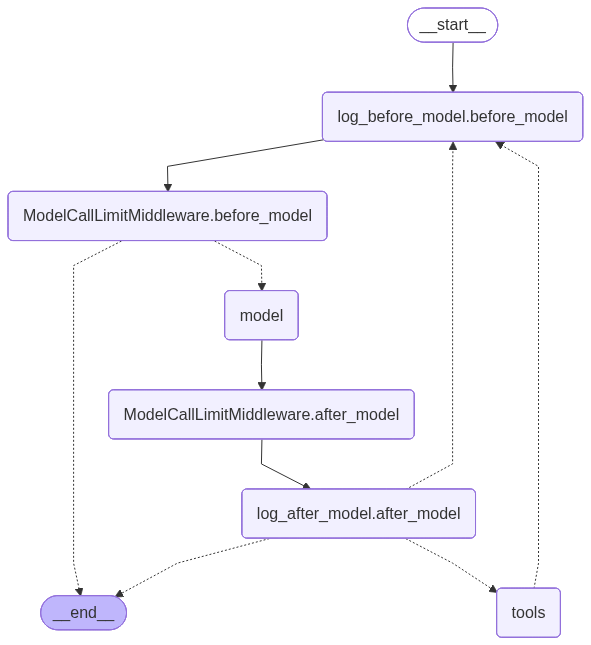

In [36]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

---
## ❓ Question #3:

How does **Agentic RAG** differ from traditional RAG? What are the advantages and potential disadvantages of letting the agent decide when to retrieve information?

##### ✅ Answer:
In Agentic RAG, retrieval is treated as a tool that the agent can invoke only when needed.
User query → Model reasons →
    ├─ Call retriever tool (if needed)
    └─ Answer directly (if not needed)

The agent:
- Reasons about whether it already knows the answer
- Decides when to retrieve and what to retrieve
- Can retrieve multiple times or not at all

✅ Advantages of Agentic RAG
1. Efficiency
- Avoids unnecessary retrieval calls
- Reduces latency and cost

2. Better reasoning
- Retrieval can happen mid-reasoning
- The agent can refine queries based on prior tool results

3. More natural behavior
- Mimics how humans think (“Do I need to look this up?”)
- Enables multi-step research and synthesis

4. Flexible workflows
- Retrieval can be combined with other tools (calculators, APIs, databases)

⚠️ Potential Disadvantages
1. Higher complexity
- Harder to debug than a fixed pipeline
- More moving parts (loops, tool calls, middleware)

2. Non-determinism
- The agent may choose not to retrieve when it should
- Behavior can vary across model versions or prompts

3. Risk of hallucination
- If the agent thinks it knows the answer but doesn’t
- Requires good prompting and guardrails

4. Loop risks
- Poor tool descriptions or prompts can cause over-retrieval or infinite loops

## ❓ Question #4:

Looking at the middleware examples (`log_before_model`, `log_after_model`, and `ModelCallLimitMiddleware`), describe a real-world scenario where middleware would be essential for a production agent. What specific middleware hooks would you use and why?

##### ✅ Answer:
Real-World Scenario: Enterprise Customer-Support Agent
> Imagine a production AI agent handling:
- customer queries
- internal knowledge retrieval
- API calls (tickets, refunds, billing systems)
In this environment, middleware is essential for safety, observability, and cost control.

🔹 log_before_model
Use case: 
- Audit and debugging
- Compliance (PII / prompt tracking)

Why it’s needed:
- Logs the exact prompt being sent to the model
- Helps diagnose hallucinations or unexpected behavior
- Enables traceability for regulated environments

Example benefit:
> “Why did the agent decide to call the billing API?”
→ You can inspect the exact prompt that caused the decision.

🔹 log_after_model
Use case:
- Tool-usage analysis
- Model behavior monitoring

Why it’s needed:
- Captures whether the model:
    - called a tool
    - returned a final answer

- Helps identify:
    - over-tooling
    - under-tooling
    - looping behavior

Example benefit:
Detect agents that repeatedly call retrieval tools without converging.

🔹 ModelCallLimitMiddleware
Use case:
- Cost control
- Loop protection
- Reliability

Why it’s needed:
- Prevents runaway agent loops
- Enforces a hard upper bound on model calls per request
- Protects infrastructure from infinite reasoning cycles

Example benefit:
If an agent keeps looping between “search → think → search”, the middleware stops it safely.

🧠 Which one would I use and why ?

Ideally I would use all of the above and additionally Human in the loop too. Middleware allows you to:
- Observe the agent without changing core logic
- Enforce policies centrally
- Add guardrails without modifying prompts or tools
- It transforms agents from experiments into operational systems

---
## 🏗️ Activity #2: Enhance the Agentic RAG System

Now it's your turn! Enhance the wellness agent by implementing ONE of the following:

### Option A: Add a New Tool
Create a new tool that the agent can use. Ideas:
- A tool that calculates BMI given height and weight
- A tool that estimates daily calorie needs
- A tool that creates a simple workout plan

### Option B: Create Custom Middleware
Build middleware that adds new functionality:
- Middleware that tracks which tools are used most frequently
- Middleware that adds a friendly greeting to responses
- Middleware that enforces a response length limit

### Option C: Improve the RAG Tool
Enhance the retrieval tool:
- Add metadata filtering
- Implement reranking of results
- Add source citations with relevance scores

In [ ]:
# Add BMI calculator tool

from langchain_core.tools import tool


# Implement your enhancement below
@tool
def bmi(height_cm: float, weight_kg: float) -> str:
    """Calculate BMI (Body Mass Index) from height (cm) and weight (kg).
    
    Use when the user asks for BMI or weight category based on height/weight.
    
    Args:
        height_cm: Height in centimeters (e.g., 175)
        weight_kg: Weight in kilograms (e.g., 72)
    """
    if height_cm <= 0 or weight_kg <= 0:
        return "Error: height_cm and weight_kg must be positive numbers."

    h_m = height_cm / 100.0
    bmi_val = weight_kg / (h_m ** 2)

    # Standard BMI categories (adult)
    if bmi_val < 18.5:
        category = "Underweight"
    elif bmi_val < 25:
        category = "Normal weight"
    elif bmi_val < 30:
        category = "Overweight"
    else:
        category = "Obesity"

    return f"BMI = {bmi_val:.1f} ({category})"


In [40]:
# Test your enhanced agent here
from langchain.agents import create_agent

# Define our tools - include the RAG tool and the BMI calculator from above
rag_tools = [search_wellness_knowledge, bmi]

# Create the agentic RAG system with BMI calculator added
wellness_agent = create_agent(
    model="gpt-5",
    tools=rag_tools,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, bmi calculation and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Wellness Agent created with middleware and BMI calculator!")
# Test the wellness agent
print("Testing Wellness Agent")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "My height is 175cm and weight is 72kg. What's my BMI?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Wellness Agent created with middleware and BMI calculator!
Testing Wellness Agent
[LOG] Model call #11 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'bmi', 'args': {'height_cm': 175, 'weight_kg': 72}, 'id': 'call_b2SEiTFtzZA1NMgE1VnLi4W3', 'type': 'tool_call'}, {'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories and interpretation (e.g., WHO ranges)'}, 'id': 'call_74HVeetJtxUHwfRlgiXCYfAD', 'type': 'tool_call'}]
[LOG] Model call #12 - Messages in state: 4
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories WHO: underweight <18.5, normal 18.5-24.9, overweight 25-29.9, obesity ≥30'}, 'id': 'call_OJCIqoxhFmd20biJcswbApUN', 'type': 'tool_call'}]
[LOG] Model call #13 - Messages in state: 6
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Your BMI is 23.5, which falls in the normal weight range.

Note: BMI is a screening tool and doesn’t account for muscle mass, body c

# Tool Usage Tracked middleware

In [58]:
from collections import Counter
from langchain.agents.middleware import after_model

# Global counter (like model_call_count)
tool_usage_counter = Counter()

def _extract_tool_calls_from_message(msg):
    """Return a list of tool calls from the last AIMessage, or [] if none."""
    if msg is None:
        return []
    tool_calls = getattr(msg, "tool_calls", None)
    return tool_calls or []

def _extract_tool_name(tool_call):
    """Tool calls can be dict-like or object-like depending on model/provider."""
    if isinstance(tool_call, dict):
        return tool_call.get("name")
    return getattr(tool_call, "name", None)

@after_model
def track_tool_usage_after_model(state, runtime):
    """
    Called after each model invocation.
    Counts tool calls requested by the model (not necessarily executed).
    """
    messages = state.get("messages", [])
    last_message = messages[-1] if messages else None

    tool_calls = _extract_tool_calls_from_message(last_message)
    for call in tool_calls:
        name = _extract_tool_name(call)
        if name:
            tool_usage_counter[name] += 1

    return None  # no state modification

def tool_usage_report() -> str:
    """Human-readable summary of tool usage so far."""
    if not tool_usage_counter:
        return "Tool usage counts: (no tools requested)"
    parts = [f"{name}: {count}" for name, count in tool_usage_counter.most_common()]
    return "Tool usage counts: " + ", ".join(parts)

def tool_usage_most_used():
    """Most frequently requested tool name (or None)."""
    if not tool_usage_counter:
        return None
    return tool_usage_counter.most_common(1)[0][0]


In [ ]:
# Test your enhanced agent here
from langchain.agents import create_agent

# Define our tools - include the RAG tool and the BMI calculator from above
rag_tools = [search_wellness_knowledge, bmi]

wellness_agent = create_agent(
    model="gpt-5",
    tools=rag_tools,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, bmi calculation and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter,
        track_tool_usage_after_model
    ]
)


Wellness Agent created with middleware and BMI calculator!
Testing Wellness Agent
[LOG] Model call #16 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'bmi', 'args': {'height_cm': 175, 'weight_kg': 72}, 'id': 'call_TXtvzVOTIubJJK6Y6FWOUzzx', 'type': 'tool_call'}, {'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories normal overweight underweight WHO or CDC ranges'}, 'id': 'call_8rQnGIWD2VvOA74W70F6muBM', 'type': 'tool_call'}]
[LOG] Model call #17 - Messages in state: 4
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories: underweight, normal weight, overweight, obesity ranges (WHO/CDC)'}, 'id': 'call_jzFbd4DKERuQUgvRdC6tW4TQ', 'type': 'tool_call'}]
[LOG] Model call #18 - Messages in state: 6
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Your BMI is 23.5. If you’d like, I can explain what that means for health and how BMI relates to factors like body composition and

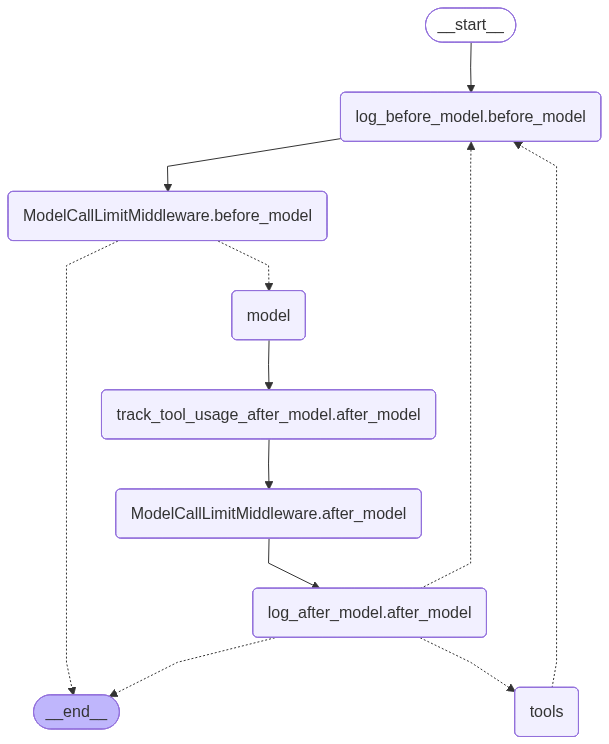

In [60]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

In [61]:

print("Wellness Agent created with middleware and BMI calculator!")
# Test the wellness agent
print("Testing Wellness Agent")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "My height is 175cm and weight is 72kg. What's my BMI?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "Give me tips on how to improve my sleep?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)
print("\n" + "=" * 50)


response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "My height is 200cm and weight is 84kg. What's my BMI?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)
print("\n" + "=" * 50)

# After the run, print report
print(tool_usage_report())
print("Most used tool:", tool_usage_most_used())
print("\n" + "=" * 50)


Wellness Agent created with middleware and BMI calculator!
Testing Wellness Agent
[LOG] Model call #24 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'bmi', 'args': {'height_cm': 175, 'weight_kg': 72}, 'id': 'call_b5nSTeIjrCEyx4pqaV6kQylB', 'type': 'tool_call'}, {'name': 'search_wellness_knowledge', 'args': {'query': 'adult BMI categories ranges normal overweight underweight obesity WHO or CDC'}, 'id': 'call_QhVUfjYv12S7q8YhnJ7fOJ9w', 'type': 'tool_call'}]
[LOG] Model call #25 - Messages in state: 4
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories: underweight, normal weight, overweight, obesity ranges adults WHO CDC'}, 'id': 'call_ZeKVMvVydZCijtLgvB0PGh74', 'type': 'tool_call'}]
[LOG] Model call #26 - Messages in state: 6
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Your BMI is 23.5, which falls in the normal weight range for adults. 

Note: BMI is a screening tool and doesn’